# NOAA Dataset: Predictive Model Development for Significant Wave Height

### 1. Setup and Data Loading
Loading the cleaned dataset and preparing for model development.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme(style="whitegrid")

In [4]:
df = pd.read_csv('../data/NOAA_data_cleaned.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values(by='date_time').set_index('date_time')

### 2. Feature Engineering and Preprocessing

In [5]:
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

# Create lag features
for i in range(1, 4):
    df[f'wave_height_lag_{i}'] = df['significant_wave_height (m)'].shift(i)

df = df.dropna()

### 3. Model Development

In [6]:
TARGET = 'significant_wave_height (m)'
FEATURES = [col for col in df.columns if col != TARGET]

X = df[FEATURES]
y = df[TARGET]

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train_scaled, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


### 4. Model Evaluation and Interpretation

In [9]:
y_pred = gbr.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 0.12512602876420717
Mean Squared Error: 0.0741131299653535
R-squared: 0.07900519333304579


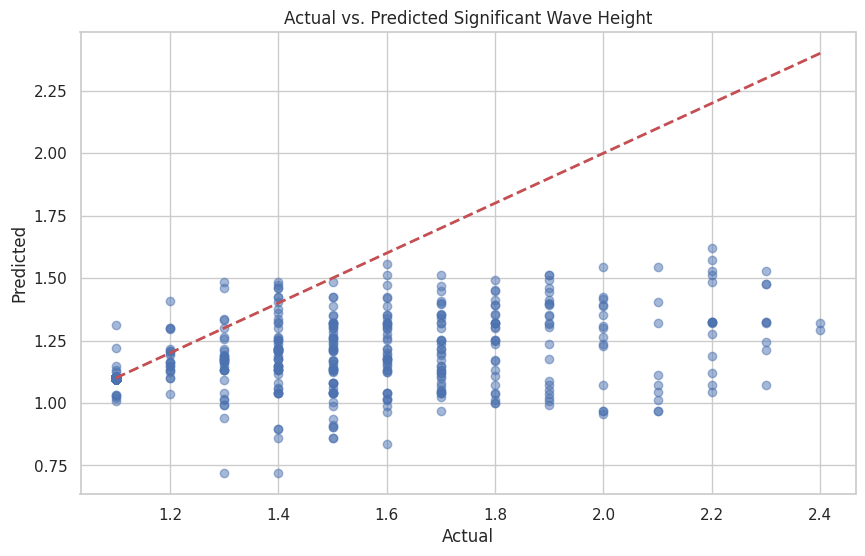

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Significant Wave Height')
plt.show()

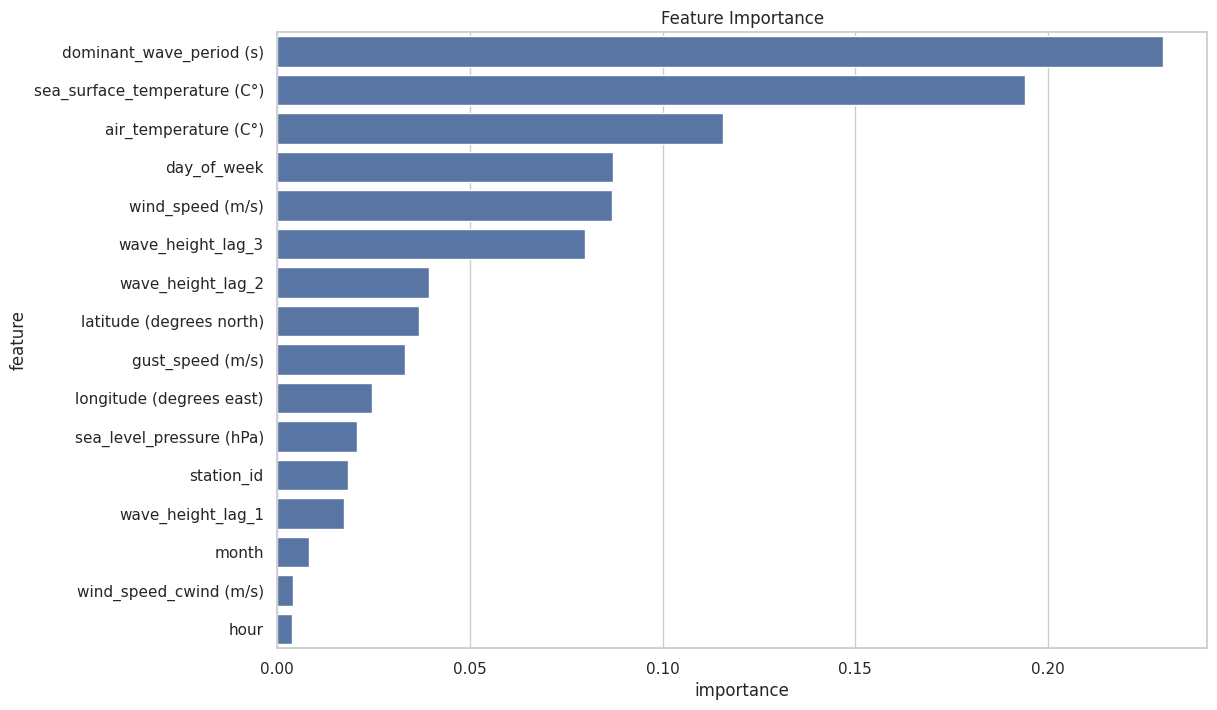

In [11]:
feature_importance = pd.DataFrame({'feature': FEATURES, 'importance': gbr.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()